In [1]:
# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer

#Librairies
import time
import torch
import random

#Raccourcis utilisé
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.utils.data as data_utils
import pandas as pd

In [2]:
def to_class(y_):
    res = np.zeros((len(y_), 11), dtype='q')
    for i in range(len(y_)):
        res[i][int(y_[i])] = 1
    return res

In [3]:
def maximum(liste):
    maxi = liste[0]
    for i in liste:
        if i >= maxi:
            maxi = i
    return maxi

In [4]:
def minimum(liste):
    mini = liste[0]
    for i in liste:
        if i <= mini:
            mini = i
    return mini

In [5]:
# Normalisation
sc = StandardScaler()

In [15]:
dfX = pd.read_csv('Molecular Dataset Dream 1.csv',sep=';')
dfY = pd.read_csv('Senteur Dataset Binaire Dream 1.csv',sep=';')

In [16]:
df = dfX.merge(dfY)

In [17]:
list_label = ['INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

#Pour les barplot
list_label_bar = ['INTENSITY', 'VALENCE', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

Dico_labels = {}
for i in range (21):
    Dico_labels[i] = list_label[i]

In [18]:
class MyNetwork(nn.Module):

    def __init__(self):
        super(MyNetwork, self).__init__()
        
        ## Activation layer
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(in_features = 3083, out_features = 2400)
        self.fc2 = nn.Linear(2400, 1200)  
        self.fc3 = nn.Linear(1200, 600)
        self.output = nn.Linear(600, 11)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):

    ## First full connection
        x = self.fc1(x)
        x = self.relu(x)
    
    ## Second full connection
        x = self.fc2(x)
        x = self.relu(x)
 
    ## Third full connection
        x = self.fc3(x)
        x = self.relu(x)
        
    ## Output layer
        x = self.output(x)
        y = self.softmax(x)
        
        return y

# Boucle

In [19]:
Label_acc_Train_15, Label_acc_Train_30 = [],[]
Label_acc_Val_15, Label_acc_Val_30 = [],[]
Label_loss_Train_15, Label_loss_Train_30 = [],[]
Label_loss_Val_15, Label_loss_Val_30 = [],[]

for j in range(len(list_label)):
    print('Prédiction du label:',Dico_labels[j])
    dfY = df[[Dico_labels[j]]]
    dfX = df
    dfX = dfX.drop(list_label,axis=1)
    dfX = dfX.drop('Unnamed: 0',axis=1)
    dfX = dfX.drop('CID',axis=1)
    
    dataX = np.float32(dfX.values)
    dataY = np.longlong(dfY.values)
    dataY = to_class(dataY)
    dataX = sc.fit_transform(dataX)
    
    DATA_Train, DATA_Test, TARGET_Train, TARGET_Test = train_test_split(dataX, dataY ,test_size=0.1)
    Batch=300
    X_train_tensor = torch.from_numpy(DATA_Train)
    Y_train_tensor = torch.from_numpy(TARGET_Train)
    X_test_tensor = torch.from_numpy(DATA_Test)
    Y_test_tensor = torch.from_numpy(TARGET_Test)

    train = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = data_utils.DataLoader(train, batch_size=Batch, shuffle=True)
    test = data_utils.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = data_utils.DataLoader(test, batch_size=Batch, shuffle=True)
    
    net = MyNetwork()
    net = net.cuda()
    LEARNING_RATE = 0.003
    MOMENTUM = 0.9
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    
    N_EPOCHS = 30   
    #print('Début de l'entrainement sur',N_EPOCHS,'Epoch')    
    
    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
    start_time = time.time()
    
    for e in range(N_EPOCHS):     
        ### boucle d'entraineement
        running_loss = 0
        running_accuracy = 0
        running_acc=0
        start_epoch_time=time.time()      
        ## Le réseau est mis en mode "entrainement"
        net.train()      
        for i, batch in enumerate(train_loader):            
            # Obtenir batch du dataloader
            x = batch[0]
            labels = batch[1]
            # déplacer le batch sur le GPU
            x = x.cuda()
            labels = labels.cuda()
            # Calcul de l'output et les loss
            output = net(x)
            y = output         
            loss = criterion(y, torch.max(labels, 1)[1])          
            # Réinitialisation du gradients
            optimizer.zero_grad()           
            # Calculs du gradients
            loss.backward()           
            # Appliquecation d'une étape d'optimisation de l'algorithme de descente pour mettre à jour les poids
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                running_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
                
        epoch_loss.append(running_loss/len(train))
        epoch_acc.append(running_accuracy/len(train))
         
        ### Boucle de valisation
        ## Le réseau est mis en mode validation
        net.eval()
        running_val_loss = 0
        running_val_accuracy = 0               
        for i, batch in enumerate(test_loader):
            with torch.no_grad():
                x = batch[0]
                labels = batch[1]
                x = x.cuda()
                labels = labels.cuda()
                output = net(x)
                y = output
            
                loss = criterion(y, torch.max(labels, 1)[1])
                running_val_loss += loss.item()
                running_val_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
        epoch_val_loss.append(running_val_loss/len(test))
        epoch_val_acc.append(running_val_accuracy/len(test))
        if e == 14 :
            Label_acc_Train_15.append(maximum(epoch_acc))
            Label_acc_Val_15.append(maximum(epoch_val_acc))
            Label_loss_Train_15.append(minimum(epoch_loss))
            Label_loss_Val_15.append(minimum(epoch_val_loss))
        if e == 29 :
            Label_acc_Train_30.append(maximum(epoch_acc))
            Label_acc_Val_30.append(maximum(epoch_val_acc))
            Label_loss_Train_30.append(minimum(epoch_loss))
            Label_loss_Val_30.append(minimum(epoch_val_loss))
    #print('Dernière epoch: Acc:',running_accuracy/len(train))
    interval = time.time() - start_time
    print ('Best accuracy d entrainement',maximum(epoch_acc))
    print ('Temps total en secondes:', interval)

    print(  )

Prédiction du label: INTENSITY/STRENGTH
Best accuracy d entrainement 0.7307706873698163
Temps total en secondes: 49.504921436309814

Prédiction du label: VALENCE/PLEASANTNESS
Best accuracy d entrainement 0.6355235750804772
Temps total en secondes: 47.1052348613739

Prédiction du label: BAKERY
Best accuracy d entrainement 0.9022912327210756
Temps total en secondes: 49.04100584983826

Prédiction du label: SWEET
Best accuracy d entrainement 0.704184813482295
Temps total en secondes: 47.094950675964355

Prédiction du label: FRUIT
Best accuracy d entrainement 0.856807422836584
Temps total en secondes: 49.076030015945435

Prédiction du label: FISH
Best accuracy d entrainement 0.9402385911759137
Temps total en secondes: 49.67437148094177

Prédiction du label: GARLIC
Best accuracy d entrainement 0.9032758947169097
Temps total en secondes: 49.5144476890564

Prédiction du label: SPICES
Best accuracy d entrainement 0.8095436470365461
Temps total en secondes: 49.38181471824646

Prédiction du label

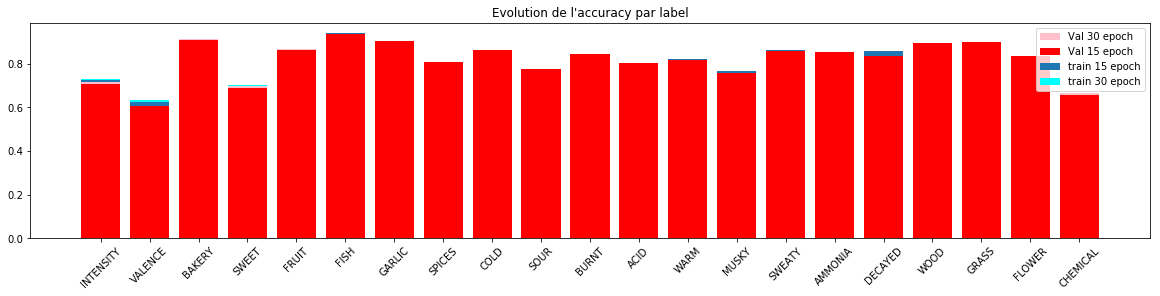

In [20]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)

d = plt.bar(list_label_bar,Label_acc_Train_30,color=['cyan'])
c = plt.bar(list_label_bar,Label_acc_Train_15)
a = plt.bar(list_label_bar,Label_acc_Val_30,color=['pink'])
b = plt.bar(list_label_bar,Label_acc_Val_15,color=['red'])


plt.title("Evolution de l'accuracy par label")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

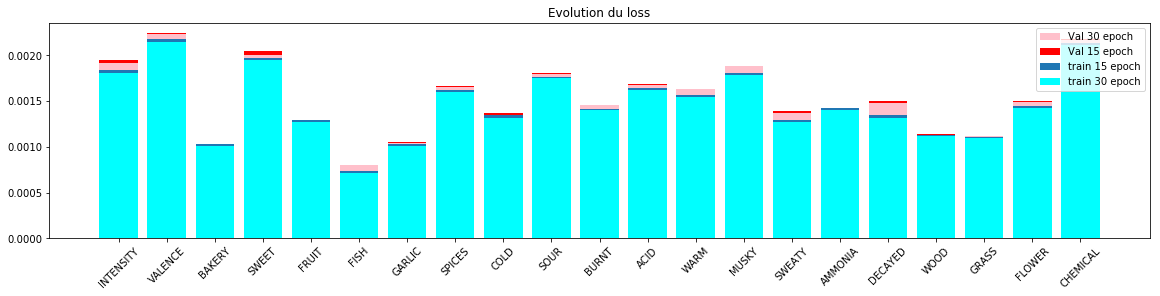

In [21]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)


b = plt.bar(list_label_bar,Label_loss_Val_15,color=['red'])
a = plt.bar(list_label_bar,Label_loss_Val_30,color=['pink'])

c = plt.bar(list_label_bar,Label_loss_Train_15)
d = plt.bar(list_label_bar,Label_loss_Train_30,color=['cyan'])
plt.title("Evolution du loss")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)